In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest'], subs)
print(X[0].shape)

847
(847, 264, 124)


In [3]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83
N = X[0].shape[0]

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [tr/20*N, 0.8*N], 2*N)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

ts = [ts for ts in filter_design_ts(X[0])]
ts = np.stack(ts)
print(ts.shape)

(847, 264, 124)


In [4]:
import numpy as np
import scipy.signal as sps
from collections import deque

def normalisa(a, order=2, axis=-1):
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2 == 0] = 1
    return a / np.expand_dims(l2, axis)

def embed(x, embd, lag):
    N = len(x)
    hidx = np.arange(embd * lag, step=lag)
    vidx = np.arange(N - (embd - 1) * lag)
    vidx = vidx.T
    Nv = len(vidx)
    U = np.array([x, ] * embd)
    W = np.array([hidx, ] * Nv).T + np.array([vidx, ] * embd)
    u = np.zeros((embd, Nv))
    for i in range(embd):
        for j in range(Nv):
            u[i, j] = U[i, W[i, j]]
    return u.T

def timeshifted(timeseries, shift):
    ts = deque(timeseries)      
    ts.rotate(shift)
    return np.asarray(ts)   

def iaaft(x, maxiter=1000, atol=1e-8, rtol=1e-10):
    """Return iterative amplitude adjusted Fourier transform surrogates.
    this function have been taken from teh NoLiTSA package, 
    Copyright (c) 2015-2016, Manu Mannattil.
    All rights reserved.

    Returns phase randomized, amplitude adjusted (IAAFT) surrogates with
    the same power spectrum (to a very high accuracy) and distribution
    as the original data using an iterative scheme (Schreiber & Schmitz
    1996).

    Parameters
    ----------
    x : array
        1-D real input array of length N containing the time series.
    maxiter : int, optional (default = 1000)
        Maximum iterations to be performed while checking for
        convergence.  The scheme may converge before this number as
        well (see Notes).
    atol : float, optional (default = 1e-8)
        Absolute tolerance for checking convergence (see Notes).
    rtol : float, optional (default = 1e-10)
        Relative tolerance for checking convergence (see Notes).

    Returns
    -------
    y : array
        Surrogate series with (almost) the same power spectrum and
        distribution.
    i : int
        Number of iterations that have been performed.
    e : float
        Root-mean-square deviation (RMSD) between the absolute squares
        of the Fourier amplitudes of the surrogate series and that of
        the original series.

    Notes
    -----
    To check if the power spectrum has converged, we see if the absolute
    difference between the current (cerr) and previous (perr) RMSDs is
    within the limits set by the tolerance levels, i.e., if abs(cerr -
    perr) <= atol + rtol*perr.  This follows the convention used in
    the NumPy function numpy.allclose().

    Additionally, atol and rtol can be both set to zero in which
    case the iterations end only when the RMSD stops changing or when
    maxiter is reached.
    """
    # Calculate "true" Fourier amplitudes and sort the series.
    ampl = np.abs(np.fft.rfft(x))
    sort = np.sort(x)

    # Previous and current error.
    perr, cerr = (-1, 1)

    # Start with a random permutation.
    t = np.fft.rfft(np.random.permutation(x))

    for i in range(maxiter):
        # Match power spectrum.
        s = np.real(np.fft.irfft(ampl * t / np.abs(t), n=len(x)))

        # Match distribution by rank ordering.
        y = sort[np.argsort(np.argsort(s))]

        t = np.fft.rfft(y)
        cerr = np.sqrt(np.mean((ampl ** 2 - np.abs(t) ** 2) ** 2))

        # Check convergence.
        if abs(cerr - perr) <= atol + rtol * abs(perr):
            break
        else:
            perr = cerr

    # Normalize error w.r.t. mean of the "true" power spectrum.
    return y, i, cerr / np.mean(ampl ** 2)    

def pTE(z, tau=1, dimEmb=1, surr=None, Nsurr=19):
    """Returns pseudo transfer entropy.

    Parameters
    ----------
    z : array
        array of arrays, containing all the time series.
    tau : integer
        delay of the embedding.  
    dimEMb : integer
        embedding dimension, or model order.     
    surr : boolean
        if True it computes the maximum value obtained using 19 times shifted
        surrogates      

    Returns
    -------
    pte : array
        array of arrays. The dimension is (# time series, # time series). 
        The diagonal is 0, while the off diagonal term (i, j) corresponds
        to the pseudo transfer entropy from time series i to time series j.
    ptesurr : array
        array of arrays. The dimension is (# time series, # time series). 
        The diagonal is 0, while the off diagonal term (i, j) corresponds
        to the pseudo transfer entropy from time series i to surrogate time 
        series j.    
    In case of surrogates it returns pte and the maximum value obtained with 
    surrogares ptesurr   
    """

    NN, T = np.shape(z)
    Npairs = NN * (NN - 1)
    pte = np.zeros((NN, NN))
    ptesurr = np.zeros((NN, NN))  
    z = normalisa(sps.detrend(z))
    channels = np.arange(NN, step=1)

    for i in channels:
        EmbdDumm = embed(z[i], dimEmb + 1, tau)
        Xtau = EmbdDumm[:, :-1]
        for j in channels:
            if i != j:
                Yembd = embed(z[j], dimEmb + 1, tau)
                Y = Yembd[:, -1]
                Ytau = Yembd[:, :-1]
                XtYt = np.concatenate((Xtau, Ytau), axis=1)
                YYt = np.concatenate((Y[:, np.newaxis], Ytau), axis=1)
                YYtXt = np.concatenate((YYt, Xtau), axis=1)
#                 print(np.cov(YYtXt.T))
#                 if j == 2:
#                     raise 'bad'

                if dimEmb > 1:
                    ptedum = np.linalg.det(np.cov(XtYt.T)) * np.linalg.det(np.cov(YYt.T)) / (
                            np.linalg.det(np.cov(YYtXt.T)) * np.linalg.det(np.cov(Ytau.T)))
                else:
                    ptedum = np.linalg.det(np.cov(XtYt.T)) * np.linalg.det(np.cov(YYt.T)) / (
                            np.linalg.det(np.cov(YYtXt.T)) * np.cov(Ytau.T))

                pte[i, j] = 0.5 * np.log(ptedum)
   
    if surr != None:   
        surrogate = np.zeros((NN, Nsurr, T))  
        if surr == 'ts':
            for k in range(NN):
                for n in range(Nsurr):
                    surrogate[k, n] = timeshifted(z[k], -(n + dimEmb + 1))
        if surr == 'iaaft': 
            for k in range(NN):
                for n in range(Nsurr):
                    surrogate[k, n], a, b = iaaft(z[k])
        for i in channels:
            EmbdDumm = embed(z[i], dimEmb + 1, tau)
            Xtau = EmbdDumm[:, :-1]
            for j in channels:
                if i != j:
                    ptedumold = float('-inf') 
                    for n in range(Nsurr):                      
                        Yembd = embed(surrogate[j, n], dimEmb + 1, tau)
                        Y = Yembd[:, -1]
                        Ytau = Yembd[:, :-1]
                        XtYt = np.concatenate((Xtau, Ytau), axis=1)
                        YYt = np.concatenate((Y[:, np.newaxis], Ytau), axis=1)
                        YYtXt = np.concatenate((YYt, Xtau), axis=1)

                        if dimEmb > 1:
                            ptedum = np.linalg.det(np.cov(XtYt.T)) * np.linalg.det(np.cov(YYt.T)) / (
                                    np.linalg.det(np.cov(YYtXt.T)) * np.linalg.det(np.cov(Ytau.T)))
                        else:
                            ptedum = np.linalg.det(np.cov(XtYt.T)) * np.linalg.det(np.cov(YYt.T)) / (
                                    np.linalg.det(np.cov(YYtXt.T)) * np.cov(Ytau.T))
                        if ptedum > ptedumold:
                            ptedumold = ptedum
                    ptesurr[i, j] = 0.5 * np.log(ptedumold)          
                       
    return pte, ptesurr  

print('Complete')

Complete


In [51]:
embed(np.array([1,2,3,4,5,6]), 3, 1)

array([[1., 2., 3.],
       [2., 3., 4.],
       [3., 4., 5.],
       [4., 5., 6.]])

In [40]:
te = pTE(ts[0], tau=3, dimEmb=5)[0]

print(te.shape)

(264, 264)


In [37]:
import torch

def mycovar(ts1, ts2):
    mu1 = torch.mean(ts1, dim=1, keepdims=True)
    mu2 = torch.mean(ts2, dim=1, keepdims=True)
    return torch.mean((ts1-mu1)*(ts2-mu2), dim=1)

def fast_te(ts, tau=1, R=264, delay=1):
    i,j = np.meshgrid(np.arange(R),np.arange(R),indexing='ij')
    i = i.reshape(-1) # x
    j = j.reshape(-1) # y
    newts = torch.stack([ts[:,t:t-tau-delay+1] for t in range(tau)] + [ts[:,(tau+delay-1):]], dim=1)
    newts2 = torch.stack([ts[:,(tau+delay-1):]] + [ts[:,t:t-tau-delay+1] for t in range(tau)], dim=1)
    # Input 1
    yt = torch.zeros(i.shape[0],tau,tau).double().cuda()
    for t1 in range(tau):
        for t2 in range(tau):
            yt[:,t1,t2] = mycovar(newts[j,t1], newts[j,t2])
    # Input 2
    xtyt = torch.zeros(i.shape[0],2*tau,2*tau).double().cuda()
    for t1 in range(2*tau):
        for t2 in range(2*tau):
            a = newts[i,t1] if t1 < tau else newts[j,t1-tau] # x else y
            b = newts[i,t2] if t2 < tau else newts[j,t2-tau] # x else y
            xtyt[:,t1,t2] = mycovar(a, b)
    # Input 3
    yyt = torch.zeros(i.shape[0],1+tau,1+tau).double().cuda()
    for t1 in range(tau+1):
        for t2 in range(tau+1):
            yyt[:,t1,t2] = mycovar(newts2[j,t1], newts2[j,t2])
    # Input 4
    yytxt = torch.zeros(i.shape[0],1+2*tau,1+2*tau).double().cuda()
    for t1 in range(1+2*tau):
        for t2 in range(1+2*tau):
            a = newts2[j,t1] if t1 < tau+1 else newts[i,t1-tau-1]
            b = newts2[j,t2] if t2 < tau+1 else newts[i,t2-tau-1]
            yytxt[:,t1,t2] = mycovar(a, b)
#     print(yytxt[1])
#     print(yytxt[2])
#     raise 'bad'
    te = torch.linalg.det(xtyt)*torch.linalg.det(yyt)/(
        torch.linalg.det(yytxt)*torch.linalg.det(yt))
    te = torch.log(te)
    te = te.reshape(R,R)
    idcs = np.arange(R)
    te[idcs,idcs] = 0
    return 0.5*te

te1 = fast_te(torch.from_numpy(ts[0]).double().cuda(), tau=5, delay=3, R=264).detach().cpu().numpy()
print('Complete')

Complete


In [87]:
tes = []
nts = [normalisa(sps.detrend(ts[i])) for i in range(ts.shape[0])]
nts = np.stack(nts)
ts_t = torch.from_numpy(ts).float().cuda()

for sub in range(ts.shape[0]):
    te = fast_te(ts_t[sub],tau=5,R=264,delay=2)
    tes.append(te)
    if sub % 20 == 0:
        print(f'Finished {sub}')
        
tes = torch.stack(tes)
print('Complete')

Finished 0
Finished 20
Finished 40
Finished 60
Finished 80
Finished 100
Finished 120
Finished 140
Finished 160
Finished 180
Finished 200
Finished 220
Finished 240
Finished 260
Finished 280
Finished 300
Finished 320
Finished 340
Finished 360
Finished 380
Finished 400
Finished 420
Finished 440
Finished 460
Finished 480
Finished 500
Finished 520
Finished 540
Finished 560
Finished 580
Finished 600
Finished 620
Finished 640
Finished 660
Finished 680
Finished 700
Finished 720
Finished 740
Finished 760
Finished 780
Finished 800
Finished 820
Finished 840
Complete


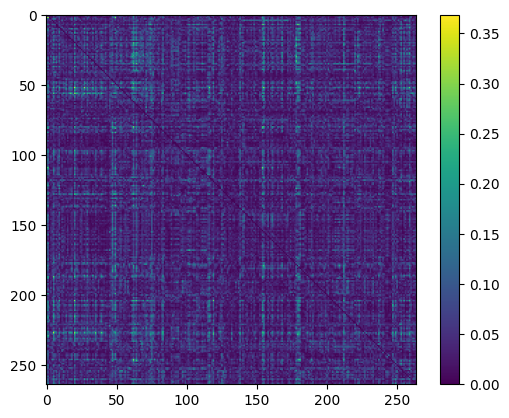

In [89]:
import matplotlib.pyplot as plt

plt.imshow(tes[600].detach().cpu().numpy())
# plt.imshow(te1-te)
plt.colorbar()
plt.show()

In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# xec = torch.from_numpy(gc).float().cuda()
xec = tes.reshape(tes.shape[0],-1).float()
xec[torch.isnan(xec)] = 0
xec[torch.isinf(xec)] = 0
xectr = xec[:600]
xect = xec[600:]

y = get_y(metadict, ['age'], subs)[0]
y_t = torch.from_numpy(y).float().cuda()
ytr = y_t[:600]
yt = y_t[600:]

print(xec.shape)
print(xectr.shape)
print(xect.shape)
print(y.shape)

torch.Size([847, 69696])
torch.Size([600, 69696])
torch.Size([247, 69696])
(847,)


In [91]:
mseLoss = nn.MSELoss()

w, _, _, _ = torch.linalg.lstsq(xectr, ytr)
yhattr = xectr@w
yhatt = xect@w
print(mseLoss(yhattr, ytr)**0.5)
print(mseLoss(yhatt, yt)**0.5)

tensor(7.3917e-05, device='cuda:0')
tensor(51.7697, device='cuda:0')


In [92]:
class MLP(nn.Module):
    def __init__(self, dim):
        super(MLP, self).__init__()
        self.l0 = nn.Linear(dim,30).float().cuda()
        self.l1 = nn.Linear(30,1).float().cuda()
        
    def forward(self, x):
        y = F.relu(self.l0(x))
        y = self.l1(y).squeeze()
        return y

mseLoss = nn.MSELoss()
    
mlp = MLP(xec.shape[1])
optim = torch.optim.Adam(mlp.parameters(), lr=1e-3, weight_decay=1e-1)

nEpochs = 10000
pPeriod = 1000

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e0)

for epoch in range(nEpochs):
    optim.zero_grad()
    yhat = mlp(xectr)
    loss = mseLoss(yhat, ytr)
    l1loss = 1e0*(torch.sum(torch.abs(mlp.l0.weight))+torch.sum(torch.abs(mlp.l0.bias)))
    (loss+l1loss).backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)**0.5} {float(l1loss)} lr: {sched._last_lr}')
        
print('Complete')
print(mseLoss(mlp(xect), yt)**0.5)

0 184.7385399016675 3960.7177734375 lr: [0.001]
1000 49.29794967132888 2290.615966796875 lr: [0.001]
2000 37.81385586412076 1534.125732421875 lr: [0.001]
3000 30.830363142588936 1138.2352294921875 lr: [0.001]
4000 27.794060996194066 913.28564453125 lr: [0.001]
5000 26.098605461427436 836.7926635742188 lr: [0.001]
6000 24.62289063379973 820.8951416015625 lr: [0.001]
7000 23.04100958201688 811.794921875 lr: [0.001]
8000 20.953816083168853 803.6865234375 lr: [0.001]
9000 19.9199064591138 801.7730712890625 lr: [0.001]
9999 18.12933171567643 799.2965698242188 lr: [0.001]
Complete
tensor(36.4937, device='cuda:0', grad_fn=<PowBackward0>)


In [58]:
import sys 

sys.path.append('../../LatentSimilarity')

from latsim import LatSim

print('Complete')

Complete


In [94]:
sim = LatSim(1, xec.unsqueeze(1), dp=0.5, edp=0, wInit=1e-4, dim=1, temp=10)
optim = torch.optim.Adam(sim.parameters(), lr=1e-4, weight_decay=1e-4)

nEpochs = 1000
pPeriod = 100

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.95, eps=1e-7)

for epoch in range(nEpochs):
    optim.zero_grad()
    yhat = sim(xectr.unsqueeze(1), [ytr])[0][0]
    loss = mseLoss(yhat, ytr)
    loss.backward()
    optim.step()
    sched.step(loss)
    if epoch % pPeriod == 0 or epoch == nEpochs-1:
        print(f'{epoch} {float(loss)**0.5} lr: {sched._last_lr}')
        
print('Complete')

print(mseLoss(sim(xec.unsqueeze(1), [y_t], torch.arange(600,y_t.shape[0]))[0][0][600:], yt)**0.5)

0 40.081035164810956 lr: [0.0001]
100 35.63972591752864 lr: [0.0001]
200 30.357315252760227 lr: [0.0001]
300 26.939410006966327 lr: [0.0001]
400 24.95165369214346 lr: [0.0001]
500 23.332925556797683 lr: [0.0001]
600 21.994780875066418 lr: [9.5e-05]
700 20.805938694539535 lr: [9.025e-05]
800 19.50960519396071 lr: [8.573749999999999e-05]
900 18.03990074248825 lr: [7.350918906249998e-05]
999 16.71121781993732 lr: [6.30249409724609e-05]
Complete
tensor(35.4601, device='cuda:0', grad_fn=<PowBackward0>)


In [68]:
mseLoss(torch.mean(ytr),yt)**0.5

/usr/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([247])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(38.2108, device='cuda:0')